In [1]:
# PS3 Notes
import numpy as np
import pandas as pd
from skimage.io import imread, imshow
import time


In [2]:
testX = np.array(pd.read_csv("testX-Copy1.csv"))
testY = np.array(pd.read_csv("testY-Copy1.csv"))
trainX = np.array(pd.read_csv("trainX-Copy1.csv"))
trainY = np.array(pd.read_csv("trainY-Copy1.csv"))


In [3]:
'''
B

B = N(0, sigma^2 * I) - 
all weights B are initialized from a normal distribution with mean = 0 and sigma is the standard deviation

'''
a = 0


In [4]:
def get_digits(trainX, trainY, digits):
    ret_x = []
    ret_y = []
    for i in range(len(trainX)):
        if trainY[i][0] in digits:
            x = np.insert(trainX[i], 0, 1)
            ret_x.append(x)
            if trainY[i] == digits[0]:
                ret_y.append([0])
            else:
                ret_y.append([1])
    return np.array(ret_x), np.array(ret_y)

zoX, zoY = get_digits(trainX, trainY, [0, 1])

zoY.shape

(84, 1)

In [5]:
def initialize_beta(deviation, size):
    B = np.random.normal(0, deviation**2, size)
    return B

beta = initialize_beta(1, (zoX.shape[1], 1))
print(beta.shape)

(785, 1)


In [6]:
def cost(beta, X, Y, sigma):
    x_dot_beta = np.dot(X, beta)
    part1 = np.sum(x_dot_beta * (1-Y))
    
    #part 2
    part2 = np.sum(np.log(1+np.exp(-1*x_dot_beta)))
    
    #part 3
    part3 = (1 / (2 * sigma**2)) * np.linalg.norm(beta)
    return part1 + part2 + part3


#output shape should be the shape of beta

def gradient(beta, X, Y):
    x_dot_beta = np.dot(X, beta)
    p1 = ((Y-1) + ( np.exp(-1 * x_dot_beta)/ (1 + np.exp(-1*x_dot_beta))+0.01)).T
    total = np.dot(p1, X).T
    return total

def sigmoid(x):
    return 1 / (1 + np.exp(-1 * x))

gradient(beta, zoX, zoY).shape

(785, 1)

In [7]:
def gradient_descent(X, Y, sigma, learning_rate, threshold):
    beta = initialize_beta(sigma, (X.shape[1], 1))
    energies = []
    
    prev_energy = 0
    curr_energy = cost(beta, X, Y, sigma)
    energies.append(curr_energy)
    i = 0
    
    while i < 10000:
        #while np.linalg.norm(beta) > threshold and i < 1000:
        g = gradient(beta, X, Y)
        if np.linalg.norm(g) <= threshold:
            break
        beta = beta + learning_rate * g 
        prev_energy = curr_energy
        curr_energy = cost(beta, X, Y, sigma)
        energies.append(curr_energy)
        #if i%100 == 0:
        #    print(np.linalg.norm(g))
        i += 1
    return beta #np.dot(X, beta)


def convert(arr):
    ret = (arr > 0.5)*1
    return ret

def predict(beta, X):
    results = convert(sigmoid(np.dot(X, beta)))
    return results

def accuracy(a1, a2):
    same = a1 == a2
    return 100 * np.sum(same) / len(same)

def zero_one_loss(a1, a2):
    not_same = a1 != a2
    return np.sum(not_same) / len(not_same)



results = gradient_descent(zoX, zoY, 0.1, 0.0005, .001)
#trans = sigmoid(results)
print(results.shape)
#print(trans)
#print(convert(trans))
        
    

(785, 1)


In [8]:
#validation on the training data
b_test = gradient_descent(zoX, zoY, 0.1, 0.0005, 1.82)

preds_01 = predict(b_test, zoX)

print("Error Rate on training data: ", zero_one_loss(preds_01, zoY))

#testing

x_test_01, y_test_01 = get_digits(testX, testY, [0, 1])
 
test_preds_01 = predict(b_test, x_test_01)

print("Error Rate on testing data: ", zero_one_loss(test_preds_01, y_test_01))




Error Rate on training data:  0.0
Error Rate on testing data:  0.03508771929824561


In [9]:
def compare_digits(digits, xtrain, ytrain, xtest, ytest, sigma, learning_rate, threshold):
    x1, y1 = get_digits(xtrain, ytrain, digits)
    
    B = gradient_descent(x1, y1, sigma, learning_rate, threshold)
    
    train_preds = predict(B, x1)
    print("Error Rate on training data: ", zero_one_loss(train_preds, y1))
    
    x2, y2 = get_digits(xtest, ytest, digits)
    test_preds = predict(B, x2)
    
    print("Error Rate on testing data: ", zero_one_loss(test_preds, y2))
    
compare_digits([0, 1], trainX, trainY, testX, testY, 0.1, 0.0005, 2.5)

Error Rate on training data:  0.0
Error Rate on testing data:  0.008771929824561403


In [10]:
compare_digits([6, 8], trainX, trainY, testX, testY, 0.1, 0.0005, 2.5)

Error Rate on training data:  0.0
Error Rate on testing data:  0.008928571428571428


# Question 2

In [11]:
# Here we will just project the train images to the lower dimensional space, then make predictions for the same test data

In [12]:

zeroone_x, zeroone_y = get_digits(trainX, trainY, [0, 1])

def calc_row_mean(data):
    ret = []
    
    for row in data:
        ret.append([np.sum(row) / len(row)])
    return np.array(ret)

x_mean = calc_row_mean(zeroone_x)

#subtract
def subtract(d1, d2):
    return d1 - d2
x_train_adjust = subtract(zeroone_x, x_mean)

def cov(r1, r2):
    total = 0
    for i in range(len(r1)):
        total += (r1[i]) * (r2[i]) # we can do this because the means of the rows are 0 so we don't subtract
    return total / (len(r1) - 1)

# This would be significantly faster with np.cov()
# takes approx. 30 seconds
def cov_matrix(data):
    ret = np.zeros((data.shape[0], data.shape[0]))
    
    for i in range(len(data)):
        for j in range(i, len(data)):
            store = cov(data[i], data[j])
            ret[i][j] = store
            ret[j][i] = store
    return ret
    
covariance_x = cov_matrix(x_train_adjust)


In [13]:
def compute_eigen(data):
    return np.linalg.eig(data)

w, v = compute_eigen(covariance_x)

def back_2_original(data, eigenvectors, num_eigens):
    eigens = eigenvectors[:,:num_eigens]
    A_swiggle = np.dot(data.T, eigens) #(784, 10)
    original = np.dot(A_swiggle, eigens.T).T
    return original
    

PCA_10_x_train = back_2_original(x_train_adjust, v, 10)
PCA_20_x_train = back_2_original(x_train_adjust, v, 20)
PCA_30_x_train = back_2_original(x_train_adjust, v, 30)

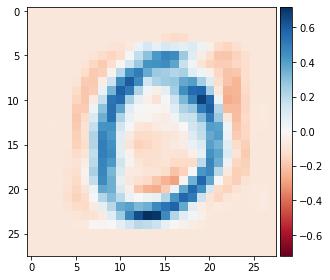

In [14]:
image1 = np.reshape(PCA_10_x_train[40][1:], (28, 28))
imshow(image1)

In [18]:
t0 = time.time()
B = gradient_descent(PCA_10_x_train, zeroone_y, 0.1, 0.0005, 2.5)
t1 = time.time()

train_preds = predict(B, PCA_10_x_train)
print("Error Rate on training data: ", zero_one_loss(train_preds, zeroone_y))

x2, y2 = get_digits(testX, testY, [0, 1])
test_preds = predict(B, x2)

print("Error Rate on testing data: ", zero_one_loss(test_preds, y2))
print("Time to train:", t1-t0)

Error Rate on training data:  0.0
Error Rate on testing data:  0.0
Time to train: 0.15922951698303223


In [22]:
t0 = time.time()
B = gradient_descent(PCA_20_x_train, zeroone_y, 0.1, 0.0002, 2.5)
t1 = time.time()

train_preds = predict(B, PCA_20_x_train)
print("Error Rate on training data: ", zero_one_loss(train_preds, zeroone_y))

x2, y2 = get_digits(testX, testY, [0, 1])
test_preds = predict(B, x2)

print("Error Rate on testing data: ", zero_one_loss(test_preds, y2))
print("Time to train:", t1-t0)

Error Rate on training data:  0.0
Error Rate on testing data:  0.0
Time to train: 0.3512747287750244


In [24]:
t0 = time.time()
B = gradient_descent(PCA_30_x_train, zeroone_y, 0.1, 0.0001, 3)
t1 = time.time()
train_preds = predict(B, PCA_30_x_train)
print("Error Rate on training data: ", zero_one_loss(train_preds, zeroone_y))

x2, y2 = get_digits(testX, testY, [0, 1])
test_preds = predict(B, x2)

print("Error Rate on testing data: ", zero_one_loss(test_preds, y2))
print("Time to train:", t1-t0)

Error Rate on training data:  0.0
Error Rate on testing data:  0.0
Time to train: 0.5110270977020264
